# Spell Checker

**Using Encoder to encode word and then comparing with all the words to find the best match.**

**Libraries**

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from random import randint, sample, shuffle
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

**Constants**

In [17]:
# Words which whose length/number of character are within
# the range [MIN_LEN, MAX_LEN] inclusive will be used.
MIN_LEN = 5
MAX_LEN = 10

# Small alphabets will be used only, remove number or special characters.
# Space is used for padding.
ALLOWED_CHARACTERS = " " + "".join([chr(i) for i in range(97, 123)])

In [18]:
def read_dataset() -> []:
    """
        Reads the file that contains correct words, each on new line.
        Preprocess the words, which inlcudes, lower case, remove special characers,
        remove words which are not in range of [MIN_LEN, MAX_LEN],
        remove words which contains digits or special characters.
        
        Returns words list.
    """
    # Reading file and spliting lines into words
    dataset = open("words_list.txt", "r").read().split("\n")

    # Striping words with space and converting to lower case
    dataset = list(map(lambda word: word.strip().lower(), dataset))

    # Filtering the words which contains special characters
    dataset = list(filter(lambda word: word.isalpha(), dataset))

    # Filtering words which are in range of min_len and max_len
    dataset = list(filter(lambda word: MIN_LEN <= len(word) <= MAX_LEN, dataset))
    
    return dataset

def encode_string(word: str) -> []:
    """
        Parameter:
            word: string/word to be encoded into list of numbers.
        
        Returns:
            encoded_word_array: integer list of size MAX_LEN
    """
    if len(word) < MAX_LEN:
        word = word + (" " * (MAX_LEN - len(word)))
    elif len(word) > MAX_LEN:
        word = word[:MAX_LEN]
    
    encoded_word_array = [ALLOWED_CHARACTERS.index(char) for char in word]
    return encoded_word_array

def decode_string(encoded_word_array: []) -> str:
    """
        Parameter:
            encoded_word_array: array which was encoded by the function 'encoded_string'.
            
        Returns:
            word: decoded word/string from encoded_word_array.
    """
    word = "".join([ALLOWED_CHARACTERS[char] for char in encoded_word_array])
    return word.strip()

def plot_predictions(x, y, title=None):
    """
        Plots a bar chart of prediction percentage.
    """
    plt.figure(figsize=(7, 4))
    plt.bar(x, y.astype(np.float32), color="teal")
    plt.title(title)
    plt.xlabel("Words")
    plt.ylabel("Prediction %")
    plt.show()
    
def plot_history(history, labels: [], ylabel: str = None):
    plt.figure(figsize=(7, 5))
    for label in labels:
        plt.plot(history[label], label=label)
    plt.title("Training History")
    
    if ylabel:
        plt.ylabel(ylabel)
    plt.xlabel("No. epoch")
    plt.legend(loc="upper left")
    plt.show()

In [19]:
def gen_misspelled_word(word: str, neg_words_size: int, max_displacement: int = 1) -> []:
    """
        Generates misspelled word from the give words. Add random character(s), 
        replace random character(s) and remove ramdom character(s) to generate misspelled words. 
        Number of character(s) that can be altered depends on max_displacement.
        
        Parameter:
            word: string for which misspelled words are to be generated.
            neg_words_size: number of misspelled words to be generated.
            max_displacement: integer within the [1, len(word)]. number of characters that can be altered.
            
        Returns:
            List of misspelled words.
    """
    misspelled_words = [word]
    word_len = len(word)
    add_rand_size = (neg_words_size - 1) // 3
    rep_rand_size = (neg_words_size - 1) // 3
    rem_rand_size = neg_words_size - add_rand_size - rep_rand_size - 1

    # Adding random character
    for _ in range(add_rand_size):
        rand_word = word

        rand_dis = min(MAX_LEN - len(word), randint(1, max_displacement))
        for _ in range(rand_dis):
            rand_idx = randint(0, word_len - 1)
            rand_chr = ALLOWED_CHARACTERS[randint(0, len(ALLOWED_CHARACTERS) - 1)]
            rand_word = rand_word[:rand_idx] + rand_chr + rand_word[rand_idx:]

        misspelled_words.append(rand_word)

    # Changing random character
    for _ in range(rep_rand_size):
        rand_word = word

        rand_dis = randint(1, max_displacement)
        for _ in range(rand_dis):
            rand_idx = randint(0, word_len - 1)
            rand_chr = ALLOWED_CHARACTERS[randint(0, len(ALLOWED_CHARACTERS) - 1)]
            rand_word = rand_word[:rand_idx] + rand_chr + rand_word[rand_idx + 1:]

        misspelled_words.append(rand_word)
        
    # Removing random character
    for _ in range(rem_rand_size):
        rand_word = word

        rand_dis = randint(1, max_displacement)
        for _ in range(rand_dis):
            rand_idx = randint(0, word_len - 1)
            rand_word = rand_word[:rand_idx] + rand_word[rand_idx + 1:]

        misspelled_words.append(rand_word)

    return misspelled_words

def gen_negative(word: str, size: int, max_displacement: int):
    """
        Generates negative words i.e. combination of misspelled and correct words other than 
        the word provided.
        
        Parameters:
            word: string for which negative words are generated.
            size: number of negative words that needs to be generated.
            max_displacement: integer within the [1, len(word)]. number of characters that can be altered.
        
        Returns:
            List of negative words.
            
    """
    other_words = list(filter(lambda w: w != word and w[0] == word[0], words_list))
    if not other_words:
        other_words = list(filter(lambda w: w != word, words_list))
    shuffle(other_words)
    
    negative = []
    neg = 0
    while neg < len(other_words) and len(negative) < size:
        negative.extend(gen_misspelled_word(other_words[neg], 5, max_displacement))
        neg = neg + 1
        
    while len(negative) < size:
        neg = neg + 1 if neg + 1 < len(other_words) else 0
        negative.append(other_words[neg])
    else:
        negative = negative[:size]
    
    return negative
    

def gen_dataset(size: int, max_displacement: int = 1):
    """
        Generates dataset for incorrect and correct words.
        
        Parameters:
            neg_words: integer. Number of misspelled words to be generated per word.
            max_displacement: integer within the [1, len(word)]. number of characters that can be altered.
            
        Returns:
            Encoded form of misspelled words and correct words and label.
    """
    pos_size = size // 2
    neg_size = size - pos_size
    
    input_1, input_2, target = [], [], []

    for word in tqdm(words_list, desc="Generating dataset"):
        input_1.extend([encode_string(word) for _ in range(size)])
        
        # Positive Target
        input_2.extend([encode_string(mw) for mw in gen_misspelled_word(word, pos_size, max_displacement)])
        target.extend([1] * pos_size)
        
        # Negative Target
        input_2.extend([encode_string(mw) for mw in gen_negative(word, neg_size, max_displacement)])
        target.extend([0] * neg_size)

    return np.array(input_1), np.array(input_2), np.array(target)

**Reading Dataset**

In [20]:
# Reading words from file
words_list = read_dataset()
print("Word Count:", len(words_list))

Word Count: 2045


**Encoding**

In [21]:
# Generating encoded dataset from words
input_1, input_2, target = gen_dataset(size=70, max_displacement=3)

trainI1, testI1, trainI2, testI2, trainT, testT = train_test_split(input_1, input_2, target, test_size=0.3)

print(f"Total size: {len(input_1)}")
print(f"Train size: {len(trainI1)}")
print(f"Test size: {len(testI1)}")

Generating dataset: 100%|██████████| 2045/2045 [00:02<00:00, 795.91it/s]


Total size: 143150
Train size: 100205
Test size: 42945


# Enocder

In [32]:
def euclidean_distance(inputs):
    a, b = inputs
    return tf.math.reduce_sum(tf.math.squared_difference(a, b), axis=1, keepdims=True)
    
def get_encoder():
    """
        Encoder encodes the give encoded word to latent space.
    """
    input_layer = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)
    
    embeddings = layers.Embedding(len(ALLOWED_CHARACTERS), 64)(input_layer)
    lstm_1 = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(embeddings)
    lstm_2 = layers.Bidirectional(layers.LSTM(32))(lstm_1)
    
    dropout_1 = layers.Dropout(0.1)(lstm_2)
    dense_1 = layers.Dense(32, activation="tanh", kernel_initializer="he_uniform")(dropout_1)
    dense_2 = layers.Dense(64, activation="tanh", kernel_initializer="he_uniform")(dense_1)
    dropout_2 = layers.Dropout(0.1)(dense_2)
    
    output_layer = layers.Dense(128, activation="tanh", kernel_initializer="he_uniform")(dropout_2)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

def get_spellchecker():
    """
        Word matching from latent space generated by encoder.
    """
    encoder = get_encoder()
    
    input_layer_1 = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)
    encoder_output_1 = encoder(input_layer_1, training=True)
    
    input_layer_2 = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)
    encoder_output_2 = encoder(input_layer_2, training=True)
    
    dist_layer = layers.Lambda(euclidean_distance)([encoder_output_1, encoder_output_2])
    
    output_layer = layers.Dense(1, activation="sigmoid")(dist_layer)
    
    model = tf.keras.models.Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)
    
    return model

In [33]:
model = get_spellchecker()
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

**Training**

In [34]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    mode="min",
    monitor="val_loss",
    patience=1,
    restore_best_weights=True
)

history = model.fit(
    [trainI1, trainI2],
    trainT, 
    epochs=30, 
    batch_size=32,
    validation_split=0.2,
    callbacks=early_stopping
)

Epoch 1/30
2506/2506 [==============================] - 38s 12ms/step - loss: 0.4124 - accuracy: 0.8229 - val_loss: 0.3164 - val_accuracy: 0.8837
Epoch 2/30
2506/2506 [==============================] - 30s 12ms/step - loss: 0.2987 - accuracy: 0.8834 - val_loss: 0.2818 - val_accuracy: 0.8881
Epoch 3/30
2506/2506 [==============================] - 35s 14ms/step - loss: 0.2528 - accuracy: 0.9000 - val_loss: 0.2221 - val_accuracy: 0.9138
Epoch 4/30
2506/2506 [==============================] - 33s 13ms/step - loss: 0.2194 - accuracy: 0.9142 - val_loss: 0.2130 - val_accuracy: 0.9143
Epoch 5/30
2506/2506 [==============================] - 34s 13ms/step - loss: 0.2006 - accuracy: 0.9207 - val_loss: 0.1875 - val_accuracy: 0.9274
Epoch 6/30
2506/2506 [==============================] - 35s 14ms/step - loss: 0.1832 - accuracy: 0.9290 - val_loss: 0.1797 - val_accuracy: 0.9301
Epoch 7/30
2506/2506 [==============================] - 34s 14ms/step - loss: 0.1731 - accuracy: 0.9328 - val_loss: 0.1776 -

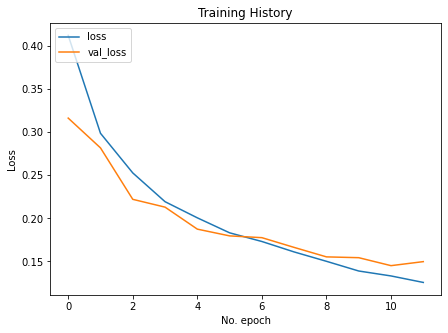

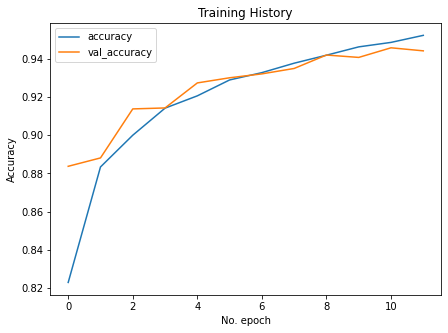

In [35]:
plot_history(history.history, ["loss", "val_loss"], ylabel="Loss")
plot_history(history.history, ["accuracy", "val_accuracy"], ylabel="Accuracy")

**Testing**

In [42]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve

model.evaluate([testI1, testI2], testT)

predT = np.round(model.predict([testI1, testI2]).ravel())

print("Confusion Matrix:")
print(confusion_matrix(testT, predT))

print("Precision Score:", precision_score(testT, predT))
print("Recall Score:", recall_score(testT, predT))
print("F1 Score:", f1_score(testT, predT))

1343/1343 [==============================] - 4s 3ms/step - loss: 0.1487 - accuracy: 0.9431
Confusion Matrix:
[[20106  1381]
 [ 1094 20364]]
Precision Score: 0.9364911473902047
Recall Score: 0.9490166837543107
F1 Score: 0.9427123116450246


**Prediction**

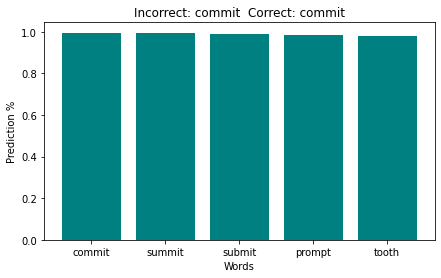

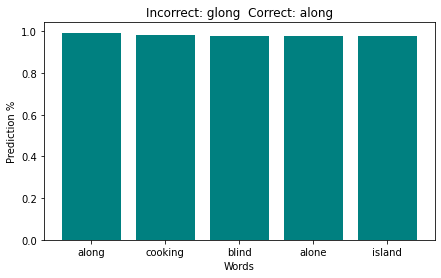

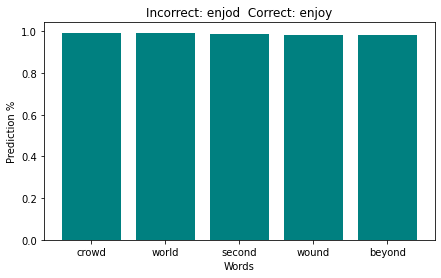

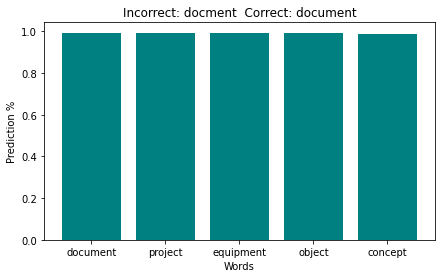

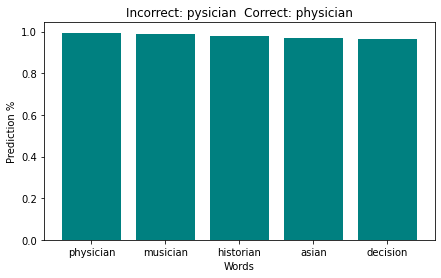

In [52]:
predictions_words = ["commit", "glong", "enjod", "docment", "pysician"]
correct_words = ["commit", "along", "enjoy", "document", "physician"]
TOP = 5

inputP1 = np.array([encode_string(pw) for pw in predictions_words])
inputP2 = np.array([encode_string(w) for w in words_list])

for i, eip in enumerate(inputP1):
    encodedIP = np.repeat([eip], len(inputP2), axis=0)
    match_predictions = model.predict([encodedIP, inputP2]).ravel()
    words_match = [words_list[idx] for idx in np.argsort(match_predictions)[-TOP:][::-1]]
    match_per = np.sort(match_predictions)[-TOP:][::-1]
    
    plot_predictions(words_match, match_per, title=f"Incorrect: {predictions_words[i]}  Correct: {correct_words[i]}")